# Trabajo Practico N1 Redes convolucionales

Alzheimer MRI Preprocessed Dataset (128 x 128)

The Data is collected from several websites/hospitals/public repositories.
The Dataset is consists of Preprocessed MRI (Magnetic Resonance Imaging) Images.
All the images are resized into 128 x 128 pixels.
The Dataset has four classes of images.
The Dataset is consists of total 6400 MRI images.
Class - 1: Mild Demented (896 images)
Class - 2: Moderate Demented (64 images)
Class - 3: Non Demented (3200 images)
Class - 4: Very Mild Demented (2240 images)
Motive
The main motive behind sharing this dataset is to design/develop an accurate framework or architecture for the classification of Alzheimers Disease.

References

* https://adni.loni.usc.edu/
* https://www.alzheimers.net/
* https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers
* https://ieeexplore.ieee.org/document/9521165
* https://catalog.data.gov/dataset/alzheimers-disease-and-healthy-aging-data
* https://www.nature.com/articles/s41598-020-79243-9
* https://cordis.europa.eu/article/id/429468-the-final-epad-dataset-is-now-available-on-the-alzheimer-s-disease-workbench

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from utils import train_model, compute_confusion_matrix

from plot_utils import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [3]:
#!pip install split-folders
import splitfolders
splitfolders.ratio('Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6400 files [00:04, 1438.98 files/s]


In [73]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

transform = transforms.ToTensor()

train_data = datasets.ImageFolder(root='output/train',transform=transform)


test_data = datasets.ImageFolder(root='output/test',transform=transform)


val_data = datasets.ImageFolder(root='output/val',transform=transform)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           num_workers=0)

valid_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=batch_size,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=0)

In [21]:
train_loader.dataset.classes

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [16]:
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
train_data

Dataset ImageFolder
    Number of datapoints: 5119
    Root location: output/train
    StandardTransform
Transform: ToTensor()

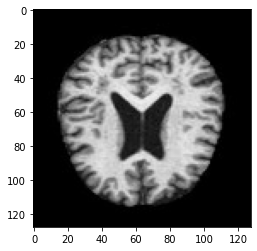

In [22]:
img = next(iter(train_loader))[0][0]
plt.imshow(transforms.ToPILImage()(img))

## Visualizacion

IndexError: index 3 is out of bounds for dimension 0 with size 3

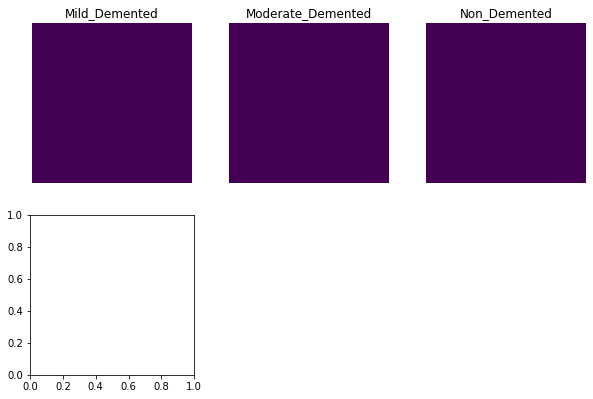

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

![image.png](attachment:c5e137cb-fc90-4f00-abe9-fdac2ebe2fbc.png)


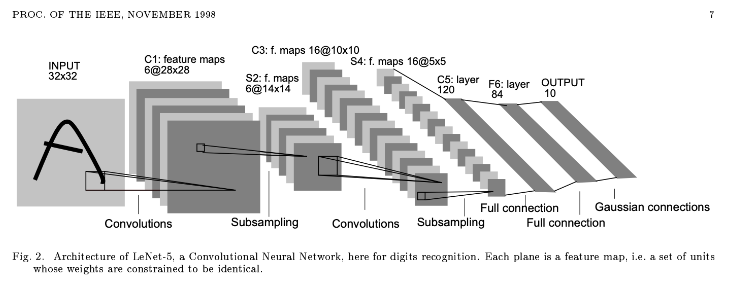

### Red

features es filtro, cada filtro tiene dimensiones 5 x 5, osea 25 parametros por filtro
tenemos 6 filtros de 5x5, osea 6x25 = 150 parametros

si nuestra imagen tiene 128 x 128, aplicamos la convolucion que agarra un sector de 5x5 hace la multiplicacion matricial y suma los valores de la mtriz, generando un escalar de 1. esos sectores de 5x5 cuantas veces lo haces? las que entre? es en base al stride? para sacar la dimension de la nueva imagen, es 128/5 ??? cual seria el tamaño de la nueva imagen.
eso se hace 6 veces random? osea llegas a 6 nuevas imagenes que son matrices formadas por escalares convolucionados.


In [95]:
NUM_EPOCAS = 3
valid_size = 0.2
batch_size = 1

In [102]:
class LeNet5(nn.Module):

    def __init__(self, n_canales_rgb, n_clases):
        super().__init__()
        # cantidad de canales y clases, a definir por el diseñador
        self.n_canales_rgb = n_canales_rgb
        self.n_clases = n_clases
        # Le net tiene dos capas convolucionales
        self.conv1 = nn.Conv2d(self.n_canales_rgb, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # y tres capas de MLPs
        self.fc1 = torch.nn.Linear(13456, 120)
        #self.fc2 = torch.nn.Linear(13456, 84)
        self.fc3 = torch.nn.Linear(84, self.n_clases)

    def forward(self, x):
        # capa convolucional
        x = self.conv1(x)
        # al resultado de la convolucion, le aplica una ReLu
        x = F.relu(x)
        # y luego un pooling
        x = F.max_pool2d(x, (2, 2))
        
        # Segunda capa convolucional
        x = self.conv2(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (2,2))
        
        # flatten de las imagenes para pasarlo a MLPs
        x = torch.flatten(x, 1)
        # MLPs con relus
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        print(x.shape)
        
        return x

In [103]:
model = LeNet5(n_canales_rgb=3, n_clases=4)
model = model.to('cpu')

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [104]:
torch.cuda.is_available()

False

In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCAS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device='cpu',
    log_interval_batch=5)

torch.Size([1, 4])
salida prop adelante tensor([[ 0.0794, -0.0712, -0.0267,  0.0240]], grad_fn=<AddmmBackward0>)
Targets tensor([0])
Epoca: 001/003 | Batch 0000/5125 | Loss: 1.3099
torch.Size([1, 4])
salida prop adelante tensor([[ 0.3602, -0.2005, -0.1571, -0.0255]], grad_fn=<AddmmBackward0>)
Targets tensor([0])
torch.Size([1, 4])
salida prop adelante tensor([[ 1.6030, -0.7228, -0.7000, -0.1997]], grad_fn=<AddmmBackward0>)
Targets tensor([0])
torch.Size([1, 4])
salida prop adelante tensor([[14.2082, -5.0364, -5.7254, -3.3953]], grad_fn=<AddmmBackward0>)
Targets tensor([0])
torch.Size([1, 4])
salida prop adelante tensor([[15.8048, -5.6087, -6.3709, -3.7411]], grad_fn=<AddmmBackward0>)
Targets tensor([0])
torch.Size([1, 4])
salida prop adelante tensor([[14.3757, -5.1304, -5.8096, -3.4097]], grad_fn=<AddmmBackward0>)
Targets tensor([0])
Epoca: 001/003 | Batch 0005/5125 | Loss: 0.0000
torch.Size([1, 4])
salida prop adelante tensor([[14.6789, -5.1985, -5.9085, -3.4529]], grad_fn=<AddmmBackw

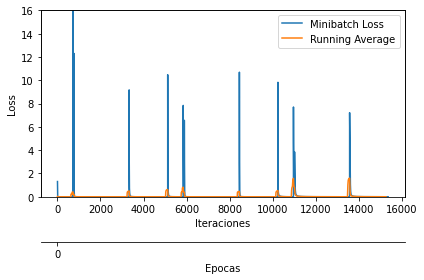

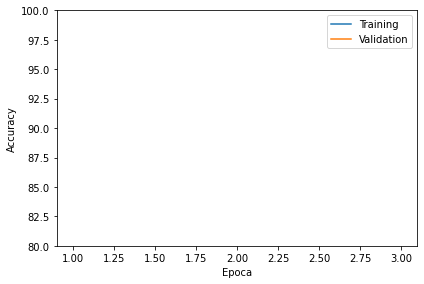

In [100]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCAS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([80, 100])
plt.show()